# Hands on Machine Learning with Scikit-Learn and Tensorflow

## Chapter 3: Classification

### Notebook by: Arunava

<hr/>
<hr/>
<hr/>

In [32]:
# Ignoring Warnings
import warnings

def fxn():
    warnings.warn('deprecated', DeprecationWarning)
    
with warnings.catch_warnings():
    warnings.simplefilter('default')
    #fxn()

## MNIST
<hr/>

In [15]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [3]:
X, y = mnist['data'], mnist['target']
print (X.shape)
print (y.shape)

(70000, 784)
(70000,)


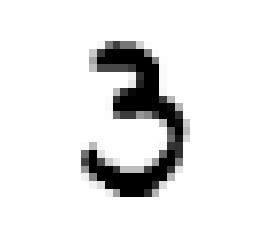

Label:  3.0


In [21]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[23456].reshape(28, 28)
plt.imshow(some_digit, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

print ('Label: ', y[23456])

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X[shuffle_index], y[shuffle_index]

## Training a Binary Classifier
<hr/>

In [9]:
y_train_3 = (y_train == 3)
y_test_3 = (y_test == 3)

In [33]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_3)
sgd_clf.predict(some_digit.ravel().reshape(1, -1))

/home/arunava/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


array([ True])

## Performance Measures
<hr/>

Implementing cross-validation from scratch

In [34]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state=42)

i = 1

for train_index, test_index in skfolds.split(X_train, y_train_3):
    clone_clf = clone(sgd_clf)
    
    X_train_f = X_train[train_index]
    y_train_f = y_train_3[train_index]
    
    X_test_f = X_train[test_index]
    y_test_f = y_train_3[test_index]
    
    clone_clf.fit(X_train_f, y_train_f)
    pred = clone_clf.predict(X_test_f)
    
    n_correct = sum(pred == y_test_f)
    acc = n_correct/len(X_test_f)
    print ('Accuracy - Iteration', i, ' :', acc)
    
    i += 1

/home/arunava/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Accuracy - Iteration 1  : 0.9592520373981301


/home/arunava/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Accuracy - Iteration 2  : 0.96955


/home/arunava/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Accuracy - Iteration 3  : 0.9651982599129957


Using `cross_val_score()` along with `sgd_clf`

In [35]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_3, cv=3, scoring='accuracy')

/home/arunava/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/arunava/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/arunava/

array([0.95925204, 0.96955   , 0.96519826])

Building a dumb classifier that predicts everything in the 'not 3' class

In [36]:
from sklearn.base import BaseEstimator

class Never3Clasifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X, y=None):
        return np.zeros((len(X), 1), dtype=bool)

In [41]:
never_3_clf = Never3Clasifier()
cross_val_score(never_3_clf, X_train, y_train_3, cv=3, scoring='accuracy')

array([0.89905, 0.89755, 0.89685])

~90% Accuaracy!

This is simply because about 10% of the classes are `3` and rest are `not_3`.

Also, if you simply predict not `3` half of the times then you are bound to get correct `90%` of the time as only `10%` of the examples are `3`.

This is the reason that `accuracy` is not a very good measure of how good a classifier really is. (Especially in cases of skewed datasets where some classes are much more frequent than others)